In [26]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import math
from mpl_toolkits import mplot3d
from pylab import rcParams
rcParams['figure.figsize'] = 10, 15

In [27]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    ax = plt.axes(projection='3d')
    ax.scatter3D(data_1[0,:], data_1[1,:], data_1[1,:], color='#336699', label=label_1)
    ax.scatter3D(data_2[0,:], data_2[1,:], data_2[1,:], color='orangered', label=label_2)
    ax.legend()
    return ax

### Random Rotation and Translation

In [28]:
theta = math.pi / 3
c, s = np.cos(theta), np.sin(theta)
R_act = np.array(
                    [[c, -s, 0],[s, c, 0], [0, 0, 1]]
                )
t_act = np.array([[-5],[6], [7]])

### Random Point set generation P, Q

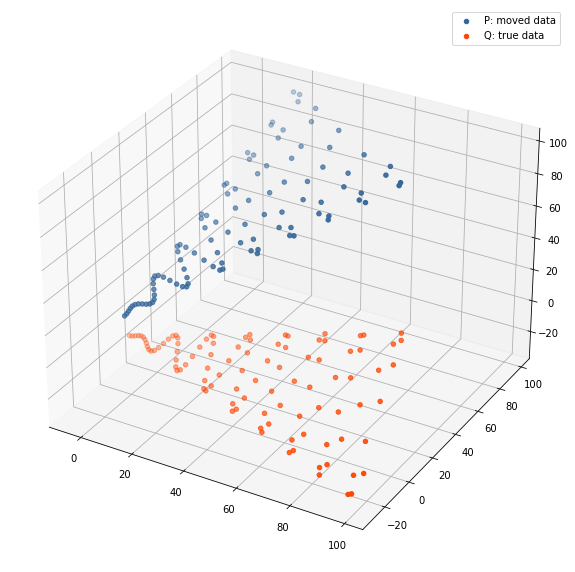

In [29]:
num_points = 100
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = R_act.dot(Q) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.show()